# Tutorial Part 10: Exploring Quantum Chemistry with GDB1k

Most of the tutorials we've walked you through so far have focused on applications to the drug discovery realm, but DeepChem's tool suite works for molecular design problems generally. In this tutorial, we're going to walk through an example of how to train a simple molecular machine learning for the task of predicting the atomization energy of a molecule. (Remember that the atomization energy is the energy required to form 1 mol of gaseous atoms from 1 mol of the molecule in its standard state under standard conditions).

## Colab

This tutorial and the rest in this sequence are designed to be done in Google colab. If you'd like to open this notebook in colab, you can use the following link.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/deepchem/deepchem/blob/master/examples/tutorials/10_Exploring_Quantum_Chemistry_with_GDB1k.ipynb)

## Setup

To run DeepChem within Colab, you'll need to run the following cell of installation commands. This will take about 5 minutes to run to completion and install your environment.

In [1]:
!curl -Lo conda_installer.py https://raw.githubusercontent.com/deepchem/deepchem/master/scripts/colab_install.py
import conda_installer
conda_installer.install()
!/root/miniconda/bin/conda info -e

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3490  100  3490    0     0  31727      0 --:--:-- --:--:-- --:--:-- 31727


add /root/miniconda/lib/python3.6/site-packages to PYTHONPATH
all packages are already installed


# conda environments:
#
base                  *  /root/miniconda



In [2]:
!pip install --pre deepchem
import deepchem
deepchem.__version__

'2.4.0-rc1.dev'

With our setup in place, let's do a few standard imports to get the ball rolling.

In [3]:
import os
import unittest
import numpy as np
import deepchem as dc
import numpy.random
from deepchem.utils.evaluate import Evaluator
from sklearn.ensemble import RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge

The ntext step we want to do is load our dataset. We're using a small dataset we've prepared that's pulled out of the larger GDB benchmarks. The dataset contains the atomization energies for 1K small molecules.

In [7]:
!wget https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/gdb1k.sdf

--2020-09-18 17:21:26--  https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/gdb1k.sdf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1384016 (1.3M) [text/plain]
Saving to: ‘gdb1k.sdf’

gdb1k.sdf           100%[===================>]   1.32M  --.-KB/s    in 0.1s    

2020-09-18 17:21:26 (13.8 MB/s) - ‘gdb1k.sdf’ saved [1384016/1384016]



In [8]:
tasks = ["atomization_energy"]
dataset_file = "gdb1k.sdf"
smiles_field = "smiles"
mol_field = "mol"

We now need a way to transform molecules that is useful for prediction of atomization energy. This representation draws on foundational work [1] that represents a molecule's 3D electrostatic structure as a 2D matrix $C$ of distances scaled by charges, where the $ij$-th element is represented by the following charge structure.

$C_{ij} = \frac{q_i q_j}{r_{ij}^2}$

If you're observing carefully, you might ask, wait doesn't this mean that molecules with different numbers of atoms generate matrices of different sizes? In practice the trick to get around this is that the matrices are "zero-padded." That is, if you're making coulomb matrices for a set of molecules, you pick a maximum number of atoms $N$, make the matrices $N\times N$ and set to zero all the extra entries for this molecule. (There's a couple extra tricks that are done under the hood beyond this. Check out reference [1] or read the source code in DeepChem!)

DeepChem has a built in featurization class `dc.feat.CoulombMatrixEig` that can generate these featurizations for you.

In [9]:
featurizer = dc.feat.CoulombMatrixEig(23, remove_hydrogens=False)

Note that in this case, we set the maximum number of atoms to $N = 23$. Let's now load our dataset file into DeepChem. As in the previous tutorials, we use a `Loader` class, in particular `dc.data.SDFLoader` to load our `.sdf` file into DeepChem. The following snippet shows how we do this:

In [10]:
loader = dc.data.SDFLoader(
      tasks=["atomization_energy"],
      featurizer=featurizer)
dataset = loader.create_dataset(dataset_file, shard_size=1000)

/usr/local/lib/python3.6/dist-packages/deepchem/feat/molecule_featurizers/coulomb_matrices.py:141: RuntimeWarning: divide by zero encountered in true_divide
  m = np.outer(z, z) / d


For the purposes of this tutorial, we're going to do a random split of the dataset into training, validation, and test. In general, this split is weak and will considerably overestimate the accuracy of our models, but for now in this simple tutorial isn't a bad place to get started.

In [11]:
random_splitter = dc.splits.RandomSplitter()
train_dataset, valid_dataset, test_dataset = random_splitter.train_valid_test_split(dataset)

One issue that Coulomb matrix featurizations have is that the range of entries in the matrix $C$ can be large. The charge $q_1q_2/r^2$ term can range very widely. In general, a wide range of values for inputs can throw off learning for the neural network. For this, a common fix is to normalize the input values so that they fall into a more standard range. Recall that the normalization transform applies to each feature $X_i$ of datapoint $X$

$\hat{X_i} = \frac{X_i - \mu_i}{\sigma_i}$

where $\mu_i$ and $\sigma_i$ are the mean and standard deviation of the $i$-th feature. This transformation enables the learning to proceed smoothly. A second point is that the atomization energies also fall across a wide range. So we apply an analogous transformation normalization transformation to the output to scale the energies better. We use DeepChem's transformation API to make this happen:

In [12]:
transformers = [
    dc.trans.NormalizationTransformer(transform_X=True, dataset=train_dataset),
    dc.trans.NormalizationTransformer(transform_y=True, dataset=train_dataset)]

for dataset in [train_dataset, valid_dataset, test_dataset]:
  for transformer in transformers:
      dataset = transformer.transform(dataset)

Now that we have the data cleanly transformed, let's do some simple machine learning. We'll start by constructing a random forest on top of the data. We'll use DeepChem's hyperparameter tuning module to do this.

In [15]:
def rf_model_builder(n_estimators, max_features, model_dir):
  sklearn_model = RandomForestRegressor(n_estimators=n_estimators, 
                                        max_features=max_features)
  return dc.models.SklearnModel(sklearn_model, model_dir)
params_dict = {
    "n_estimators": [10, 100],
    "max_features": ["auto", "sqrt", "log2", None],
}

metric = dc.metrics.Metric(dc.metrics.mean_absolute_error)
optimizer = dc.hyper.GridHyperparamOpt(rf_model_builder)
best_rf, best_rf_hyperparams, all_rf_results = optimizer.hyperparam_search(
    params_dict, train_dataset, valid_dataset, transformers,
    metric=metric)

Let's build one more model, a kernel ridge regression, on top of this raw data.

In [18]:
def krr_model_builder(kernel, alpha, gamma, model_dir):
  sklearn_model = KernelRidge(kernel=kernel, alpha=alpha, gamma=gamma)
  return dc.models.SklearnModel(sklearn_model, model_dir)

params_dict = {
    "kernel": ["laplacian"],
    "alpha": [0.0001],
    "gamma": [0.0001]
}

metric = dc.metrics.Metric(dc.metrics.mean_absolute_error)
optimizer = dc.hyper.GridHyperparamOpt(krr_model_builder)
best_krr, best_krr_hyperparams, all_krr_results = optimizer.hyperparam_search(
    params_dict, train_dataset, valid_dataset, transformers,
    metric=metric)

Now that we have a reasonable choice of hyperparameters, let's evaluate the performance of our best models on the test-set.

In [26]:
rf_test_evaluator = Evaluator(best_rf, test_dataset, transformers)
rf_test_mean_absolute_score = rf_test_evaluator.compute_model_performance(
    [metric])
print("RF Test set mean absolute error %f" % (
    rf_test_mean_absolute_score["mean_absolute_error"]))

RF Test set mean absolute error 86884.273257


In [25]:
krr_test_evaluator = Evaluator(best_krr, test_dataset, transformers)
krr_test_mean_absolute_score = krr_test_evaluator.compute_model_performance(
    [metric])
print("KRR Test set mean absolute error %f" % (
    krr_test_mean_absolute_score["mean_absolute_error"]))

KRR Test set mean absolute error 94708.136381



Now, let's plot the predicted atomization energy versus the true atomization energy for the constructed model.

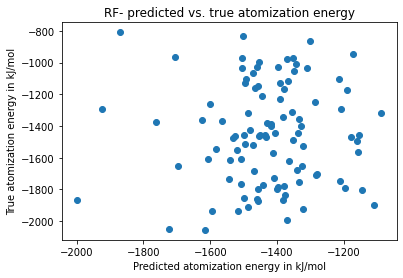

In [28]:
import matplotlib.pyplot as plt

task = "atomization_energy"
predicted_test = best_rf.predict(test_dataset)
true_test = test_dataset.y
plt.scatter(predicted_test, true_test)
plt.xlabel('Predicted atomization energy in kJ/mol')
plt.ylabel('True atomization energy in kJ/mol')
plt.title(r'RF- predicted vs. true atomization energy')
plt.show()

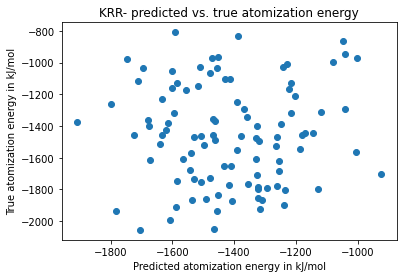

In [29]:
task = "atomization_energy"
predicted_test = best_krr.predict(test_dataset)
true_test = test_dataset.y
plt.scatter(predicted_test, true_test)
plt.xlabel('Predicted atomization energy in kJ/mol')
plt.ylabel('True atomization energy in kJ/mol')
plt.title(r'KRR- predicted vs. true atomization energy')
plt.show()

# Congratulations! Time to join the Community!

Congratulations on completing this tutorial notebook! If you enjoyed working through the tutorial, and want to continue working with DeepChem, we encourage you to finish the rest of the tutorials in this series. You can also help the DeepChem community in the following ways:

## Star DeepChem on [GitHub](https://github.com/deepchem/deepchem)
This helps build awareness of the DeepChem project and the tools for open source drug discovery that we're trying to build.

## Join the DeepChem Gitter
The DeepChem [Gitter](https://gitter.im/deepchem/Lobby) hosts a number of scientists, developers, and enthusiasts interested in deep learning for the life sciences. Join the conversation!

# Bibliography:

[1] https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.98.146401